<a href="https://colab.research.google.com/github/aarsanjani/meansquares/blob/master/TX_LabelingData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workflow

This colab aims in labeling the TX data for super spread week, safe week and improvement week as per the 'number of cases' increasing or decreasing every week.

Idea:


*   compute 7 -day moving average
*   14 days data compare with next 14 days rolling window
*   split the % as buckets
*   label the data as per bucket

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
from sklearn.mixture import GaussianMixture

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')

In [ ]:
!ls  '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/'

CA_combined_Sep09.csv
CA_Covid-19.csv
CA-CovidAug22.csv
CA_labeledData_Sep09
CA_labeledData_Sep14.csv
CA_sd_inertia_labeledData_Sep09
CA_sd_inertia_labeledData_Sep14.csv
CA_socialDistancingInertiaData_Sep09.csv
Maryland_University_SocialDistancing_Data
mask_rule.csv
mask_rule_data.csv
Newyork_combinedAug22.csv
Newyork_combined.csv
NY_Covid-19.csv
NY-CovidAug21.csv
NY-CovidAug22.csv
NY_labeledData_Aug23.csv
NY_labeledData_Aug27.csv
NY_labeledData_Sep13.csv
NY_sd_inertia_labeledData_Aug26.csv
NY_sd_inertia_labeledData_Aug27.csv
NY_sd_inertia_labeledData_Sep13.csv
NY_socialDistancingInertiaDataAug25.csv
queens_all_combined.csv
queens_all_filtered.csv
Queens_county.csv
Social_Distancing_Inertia_County.csv
TX_combined_Sep10.csv
TX-Covid_Sep10.csv
TX_socialDistancingInertiaData_Sep10.csv


### 1.1 Loading CA data

In [ ]:
TX_combined_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/TX_combined_Sep10.csv',low_memory=False)
TX_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases
0,2020-03-01,48001,Anderson County,16.0,15.0,0.0,0.0,3.0,0.0,27.49,8.910,79,54.33371,0,0.0,0
1,2020-03-02,48001,Anderson County,14.0,7.0,0.0,0.0,2.0,-1.0,27.76,10.708,95,54.33371,0,0.0,0
2,2020-03-03,48001,Anderson County,21.0,8.0,0.0,0.0,2.0,-2.0,28.24,12.118,107,54.33371,0,0.0,0
3,2020-03-04,48001,Anderson County,12.0,5.0,0.0,0.0,1.0,2.0,20.72,9.156,81,54.33371,0,0.0,0
4,2020-03-05,48001,Anderson County,18.0,13.0,0.0,0.0,3.0,-3.0,47.52,11.230,100,54.33371,0,0.0,0


In [ ]:
TX_combined_data.iloc[:,15]

0        0
1        0
2        0
3        0
4        0
        ..
36774    0
36775    0
36776    3
36777    2
36778    0
Name: New cases, Length: 36779, dtype: int64

In [ ]:
df = pd.DataFrame(columns=['Date','fips_x','County Name','retail and recreation','grocery and pharmacy','parks','transit stations','workplaces','residential','driving','m50','m50_index','population_density','mask_rule_active','mask_wearing_percent','New cases','rolling_avg_new_cases'])

In [ ]:
TX_counties = TX_combined_data['County Name'].unique()

for county in TX_counties:
  county_data = TX_combined_data[TX_combined_data['County Name'] == county]
  #print(county_data.iloc[:,15])
  county_data['rolling_avg_new_cases'] = county_data.iloc[:,15].rolling(window=7).mean()
  df = df.append(county_data)

df.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,48001,Anderson County,16.0,15.0,0.0,0.0,3.0,0.0,27.49,8.910,79,54.33371,0,0.0,0,NaN
1,2020-03-02,48001,Anderson County,14.0,7.0,0.0,0.0,2.0,-1.0,27.76,10.708,95,54.33371,0,0.0,0,NaN
2,2020-03-03,48001,Anderson County,21.0,8.0,0.0,0.0,2.0,-2.0,28.24,12.118,107,54.33371,0,0.0,0,NaN
3,2020-03-04,48001,Anderson County,12.0,5.0,0.0,0.0,1.0,2.0,20.72,9.156,81,54.33371,0,0.0,0,NaN
4,2020-03-05,48001,Anderson County,18.0,13.0,0.0,0.0,3.0,-3.0,47.52,11.230,100,54.33371,0,0.0,0,NaN


In [ ]:
print(df.shape)
TX_combined_data.shape

(73558, 17)


(36779, 16)

In [ ]:
TX_combined_data = df.copy()
TX_combined_data

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,48001,Anderson County,16.0,15.0,0.0,0.0,3.0,0.0,27.49,8.910,79,54.333710,0,0.000,0,NaN
1,2020-03-02,48001,Anderson County,14.0,7.0,0.0,0.0,2.0,-1.0,27.76,10.708,95,54.333710,0,0.000,0,NaN
2,2020-03-03,48001,Anderson County,21.0,8.0,0.0,0.0,2.0,-2.0,28.24,12.118,107,54.333710,0,0.000,0,NaN
3,2020-03-04,48001,Anderson County,12.0,5.0,0.0,0.0,1.0,2.0,20.72,9.156,81,54.333710,0,0.000,0,NaN
4,2020-03-05,48001,Anderson County,18.0,13.0,0.0,0.0,3.0,-3.0,47.52,11.230,100,54.333710,0,0.000,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36774,2020-08-31,48507,Zavala County,0.0,0.0,0.0,0.0,-30.0,0.0,0.00,2.292,23,9.125874,1,0.635,0,1.714286
36775,2020-09-01,48507,Zavala County,0.0,0.0,0.0,0.0,-30.0,0.0,0.00,3.324,34,9.125874,1,0.635,0,1.142857
36776,2020-09-02,48507,Zavala County,0.0,0.0,0.0,0.0,-31.0,0.0,0.00,7.657,79,9.125874,1,0.635,3,1.571429
36777,2020-09-03,48507,Zavala County,0.0,0.0,0.0,0.0,-33.0,0.0,0.00,3.479,36,9.125874,1,0.635,2,1.285714


In [ ]:
TX_combined_data[TX_combined_data['Date'] == '2020-08-01']

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
151,2020-08-01,48001,Anderson County,-6.0,5.0,0.0,0.0,-6.0,0.0,104.48,7.538,67,54.333710,1,0.541,13,9.857143
340,2020-08-01,48003,Andrews County,0.0,0.0,0.0,-22.0,-25.0,0.0,-17.41,2.809,60,12.464100,1,0.597,0,4.285714
529,2020-08-01,48005,Angelina County,-15.0,5.0,-3.0,-2.0,-14.0,4.0,62.99,7.438,76,108.695380,1,0.536,41,34.571429
718,2020-08-01,48007,Aransas County,13.0,16.0,44.0,0.0,-15.0,0.0,220.00,5.184,108,93.267743,1,0.746,0,4.285714
1040,2020-08-01,48013,Atascosa County,-7.0,-7.0,0.0,-28.0,-14.0,0.0,25.00,9.122,52,41.944504,1,0.802,0,1.714286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35697,2020-08-01,48495,Winkler County,0.0,0.0,0.0,0.0,-40.0,0.0,-49.49,22.197,72,9.523130,1,0.581,2,0.428571
35886,2020-08-01,48497,Wise County,-4.0,11.0,26.0,-2.0,-11.0,0.0,72.10,15.273,70,77.379978,1,0.649,2,5.571429
36075,2020-08-01,48499,Wood County,3.0,15.0,0.0,0.0,-9.0,0.0,72.77,10.248,58,70.577933,1,0.526,7,7.142857
36264,2020-08-01,48501,Yoakum County,0.0,0.0,0.0,0.0,0.0,0.0,17.32,7.017,68,10.895200,1,0.561,8,3.142857


In [ ]:
TX_combined_data.head(8)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,48001,Anderson County,16.0,15.0,0.0,0.0,3.0,0.0,27.49,8.910,79,54.33371,0,0.0,0,NaN
1,2020-03-02,48001,Anderson County,14.0,7.0,0.0,0.0,2.0,-1.0,27.76,10.708,95,54.33371,0,0.0,0,NaN
2,2020-03-03,48001,Anderson County,21.0,8.0,0.0,0.0,2.0,-2.0,28.24,12.118,107,54.33371,0,0.0,0,NaN
3,2020-03-04,48001,Anderson County,12.0,5.0,0.0,0.0,1.0,2.0,20.72,9.156,81,54.33371,0,0.0,0,NaN
4,2020-03-05,48001,Anderson County,18.0,13.0,0.0,0.0,3.0,-3.0,47.52,11.230,100,54.33371,0,0.0,0,NaN
5,2020-03-06,48001,Anderson County,8.0,10.0,0.0,0.0,3.0,-1.0,85.64,13.757,122,54.33371,0,0.0,0,NaN
6,2020-03-07,48001,Anderson County,9.0,12.0,0.0,0.0,-1.0,0.0,97.15,11.261,100,54.33371,0,0.0,0,0.0
7,2020-03-08,48001,Anderson County,13.0,18.0,0.0,0.0,1.0,0.0,30.01,9.883,88,54.33371,0,0.0,0,0.0


## clean data - fill NA

In [ ]:
TX_combined_data = TX_combined_data.fillna(0)
TX_combined_data.head(8)

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,48001,Anderson County,16.0,15.0,0.0,0.0,3.0,0.0,27.49,8.910,79,54.33371,0,0.0,0,0.0
1,2020-03-02,48001,Anderson County,14.0,7.0,0.0,0.0,2.0,-1.0,27.76,10.708,95,54.33371,0,0.0,0,0.0
2,2020-03-03,48001,Anderson County,21.0,8.0,0.0,0.0,2.0,-2.0,28.24,12.118,107,54.33371,0,0.0,0,0.0
3,2020-03-04,48001,Anderson County,12.0,5.0,0.0,0.0,1.0,2.0,20.72,9.156,81,54.33371,0,0.0,0,0.0
4,2020-03-05,48001,Anderson County,18.0,13.0,0.0,0.0,3.0,-3.0,47.52,11.230,100,54.33371,0,0.0,0,0.0
5,2020-03-06,48001,Anderson County,8.0,10.0,0.0,0.0,3.0,-1.0,85.64,13.757,122,54.33371,0,0.0,0,0.0
6,2020-03-07,48001,Anderson County,9.0,12.0,0.0,0.0,-1.0,0.0,97.15,11.261,100,54.33371,0,0.0,0,0.0
7,2020-03-08,48001,Anderson County,13.0,18.0,0.0,0.0,1.0,0.0,30.01,9.883,88,54.33371,0,0.0,0,0.0


In [ ]:
TX_combined_data['County Name'].unique()

array(['Anderson County', 'Andrews County', 'Angelina County',
       'Aransas County', 'Archer County', 'Atascosa County',
       'Austin County', 'Bailey County', 'Bandera County',
       'Bastrop County', 'Bee County', 'Bell County', 'Bexar County',
       'Blanco County', 'Bosque County', 'Bowie County',
       'Brazoria County', 'Brazos County', 'Brewster County',
       'Brooks County', 'Brown County', 'Burleson County',
       'Burnet County', 'Caldwell County', 'Calhoun County',
       'Callahan County', 'Cameron County', 'Camp County',
       'Carson County', 'Cass County', 'Castro County', 'Chambers County',
       'Cherokee County', 'Childress County', 'Clay County',
       'Coleman County', 'Collin County', 'Colorado County',
       'Comal County', 'Comanche County', 'Cooke County',
       'Coryell County', 'Crane County', 'Crockett County',
       'Culberson County', 'Dallam County', 'Dallas County',
       'Dawson County', 'Deaf Smith County', 'Delta County',
       'Dent

## verifying Rolling average with visualizations - Austin County

In [ ]:
austin_county = TX_combined_data[TX_combined_data['County Name'] == 'Austin County']
print(austin_county.shape)
austin_county.head()

(378, 17)


,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
1078,2020-03-01,48015,Austin County,15.0,10.0,0.0,0.0,4.0,0.0,45.92,14.176,60,46.452491,0,0.0,0,0.0
1079,2020-03-02,48015,Austin County,11.0,-2.0,0.0,0.0,6.0,-2.0,11.06,23.325,100,46.452491,0,0.0,0,0.0
1080,2020-03-03,48015,Austin County,10.0,2.0,0.0,0.0,6.0,-2.0,11.56,19.812,84,46.452491,0,0.0,0,0.0
1081,2020-03-04,48015,Austin County,12.0,-6.0,0.0,0.0,1.0,0.0,15.45,21.654,92,46.452491,0,0.0,0,0.0
1082,2020-03-05,48015,Austin County,17.0,6.0,0.0,0.0,1.0,-2.0,61.23,24.770,106,46.452491,0,0.0,0,0.0


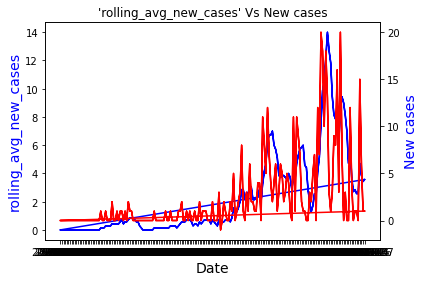

In [ ]:
fig,ax = plt.subplots()
# make a plot
ax.plot(austin_county.Date, austin_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(austin_county.Date, austin_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

## verifying Rolling average with visualizations - Dallas County

In [ ]:
dallas_county = TX_combined_data[TX_combined_data['County Name'] == 'Dallas County']

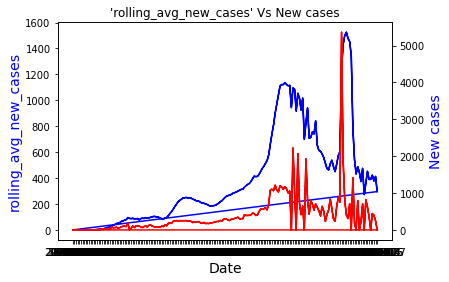

In [ ]:
fig,ax = plt.subplots()
# make a plot
ax.plot(dallas_county.Date, dallas_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(dallas_county.Date, dallas_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

## Rolling window to compare every 2 weeks with next 2 weeks

In [ ]:
TX_combined_data = TX_combined_data.sort_values(by=['Date'])
TX_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,48001,Anderson County,16.0,15.0,0.0,0.0,3.0,0.0,27.49,8.910,79,54.333710,0,0.0,0,0.0
15118,2020-03-01,48215,Hidalgo County,20.0,7.0,14.0,12.0,0.0,-3.0,-2.07,6.021,81,553.010115,0,0.0,0,0.0
26462,2020-03-01,48373,Polk County,25.0,19.0,0.0,0.0,3.0,0.0,23.02,10.595,84,48.579591,0,0.0,0,0.0
15307,2020-03-01,48217,Hill County,22.0,11.0,0.0,13.0,3.0,0.0,72.23,14.110,62,38.221430,0,0.0,0,0.0
15496,2020-03-01,48219,Hockley County,15.0,14.0,0.0,0.0,3.0,0.0,-33.99,3.309,45,25.342639,0,0.0,0,0.0


In [ ]:
TX_combined_data[TX_combined_data['fips_x'] == 48015]

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
1078,2020-03-01,48015,Austin County,15.0,10.0,0.0,0.0,4.0,0.0,45.92,14.176,60,46.452491,0,0.000,0,0.000000
1078,2020-03-01,48015,Austin County,15.0,10.0,0.0,0.0,4.0,0.0,45.92,14.176,60,46.452491,0,0.000,0,0.000000
1079,2020-03-02,48015,Austin County,11.0,-2.0,0.0,0.0,6.0,-2.0,11.06,23.325,100,46.452491,0,0.000,0,0.000000
1079,2020-03-02,48015,Austin County,11.0,-2.0,0.0,0.0,6.0,-2.0,11.06,23.325,100,46.452491,0,0.000,0,0.000000
1080,2020-03-03,48015,Austin County,10.0,2.0,0.0,0.0,6.0,-2.0,11.56,19.812,84,46.452491,0,0.000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,2020-09-05,48015,Austin County,-2.0,10.0,0.0,0.0,-21.0,0.0,114.36,12.179,52,46.452491,1,0.692,6,3.857143
1265,2020-09-06,48015,Austin County,-10.0,0.0,0.0,0.0,-14.0,0.0,78.82,8.466,36,46.452491,1,0.692,1,3.428571
1265,2020-09-06,48015,Austin County,-10.0,0.0,0.0,0.0,-14.0,0.0,78.82,8.466,36,46.452491,1,0.692,1,3.428571
1266,2020-09-07,48015,Austin County,0.0,0.0,0.0,0.0,0.0,0.0,165.66,10.781,46,46.452491,1,0.692,1,3.571429


In [ ]:
minDate = TX_combined_data['Date'].min()
print(minDate)

dateList = TX_combined_data['Date'].unique()

2020-03-01


In [ ]:
import datetime

#dt_object = datetime.fromtimestamp(date)
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']

day = datetime.datetime.strptime(minDate, '%Y-%m-%d').weekday()
if day == 6:
  day =0
elif day < 6:
  day += 1

print(day)

0


In [ ]:
index = 0
count = 0
lst = []
while index < len(dateList):
  row = []
  j = 14 - day;
  # print(index,j)
  # print(dateList[index:index+j])
  weekRange = dateList[index:index+j]
  #print(weekRange)
  index = index+j 
  day = 0
  count +=1
  row.append(count)
  row.append(weekRange.min())
  row.append(weekRange.max())
  print(row)
  lst.append(row)

[1, '2020-03-01', '2020-03-14']
[2, '2020-03-15', '2020-03-28']
[3, '2020-03-29', '2020-04-11']
[4, '2020-04-12', '2020-04-26']
[5, '2020-04-27', '2020-05-10']
[6, '2020-05-11', '2020-05-24']
[7, '2020-05-25', '2020-06-08']
[8, '2020-06-09', '2020-06-22']
[9, '2020-06-23', '2020-07-06']
[10, '2020-07-07', '2020-07-20']
[11, '2020-07-21', '2020-08-03']
[12, '2020-08-04', '2020-08-17']
[13, '2020-08-18', '2020-08-31']
[14, '2020-09-01', '2020-09-07']


In [ ]:
week_df = pd.DataFrame(lst,index=None,columns=['WeekNumber','startDate','endDate'])
week_df.head(2)

,WeekNumber,startDate,endDate
0,1,2020-03-01,2020-03-14
1,2,2020-03-15,2020-03-28


In [ ]:
average_newCases_df = pd.DataFrame(columns=['County Name',  'fips_x',  'average_per_week','startDate','endDate'])

for index, row in week_df.iterrows():
    startDate, endDate = row['startDate'], row['endDate']
    df_index = (TX_combined_data['Date'] >= startDate) & (TX_combined_data['Date'] <= endDate)
    df_weekData =  TX_combined_data.loc[df_index]
    df_base = (
      df_weekData
      .pipe(lambda x: x.assign(gains_pctg=x["rolling_avg_new_cases"]))
      .groupby(['County Name','fips_x'])
      .agg({"gains_pctg": "mean"})
      .reset_index()
      .rename(columns={"gains_pctg": "average_per_week"})
    )
    df_base['startDate'] = startDate
    df_base['endDate'] = endDate
  
    #print(startDate,endDate,df_base['average_per_week'])
    average_newCases_df = average_newCases_df.append(df_base)

In [ ]:
average_newCases_df.shape

(2835, 5)

In [ ]:
average_newCases_df[average_newCases_df['fips_x'] == 48015]

,County Name,fips_x,average_per_week,startDate,endDate
6,Austin County,48015,0.000000,2020-03-01,2020-03-14
6,Austin County,48015,0.030612,2020-03-15,2020-03-28
6,Austin County,48015,0.438776,2020-03-29,2020-04-11
6,Austin County,48015,0.387755,2020-04-12,2020-04-26
6,Austin County,48015,0.142857,2020-04-27,2020-05-10
6,Austin County,48015,0.469388,2020-05-11,2020-05-24
6,Austin County,48015,0.540816,2020-05-25,2020-06-08
6,Austin County,48015,0.979592,2020-06-09,2020-06-22
6,Austin County,48015,2.591837,2020-06-23,2020-07-06
6,Austin County,48015,5.102041,2020-07-07,2020-07-20


## Verifying average per week data Eg., Los Angeles County

In [ ]:
austin_county[(austin_county['Date'] >= '2020-03-01') & (austin_county['Date'] <= '2020-03-14') ]['rolling_avg_new_cases']

1078    0.0
1079    0.0
1080    0.0
1081    0.0
1082    0.0
1083    0.0
1084    0.0
1085    0.0
1086    0.0
1087    0.0
1088    0.0
1089    0.0
1090    0.0
1091    0.0
1078    0.0
1079    0.0
1080    0.0
1081    0.0
1082    0.0
1083    0.0
1084    0.0
1085    0.0
1086    0.0
1087    0.0
1088    0.0
1089    0.0
1090    0.0
1091    0.0
Name: rolling_avg_new_cases, dtype: float64

In [ ]:
average_newCases_df.head(10)

,County Name,fips_x,average_per_week,startDate,endDate
0,Anderson County,48001,0.0,2020-03-01,2020-03-14
1,Andrews County,48003,0.0,2020-03-01,2020-03-14
2,Angelina County,48005,0.0,2020-03-01,2020-03-14
3,Aransas County,48007,0.0,2020-03-01,2020-03-14
4,Archer County,48009,0.0,2020-03-01,2020-03-14
5,Atascosa County,48013,0.0,2020-03-01,2020-03-14
6,Austin County,48015,0.0,2020-03-01,2020-03-14
7,Bailey County,48017,0.0,2020-03-01,2020-03-14
8,Bandera County,48019,0.0,2020-03-01,2020-03-14
9,Bastrop County,48021,0.0,2020-03-01,2020-03-14


## Finding the % growth or reduction in 'new cases' on every 2 week average

In [ ]:
average_newCases_df_ = average_newCases_df.copy()

In [ ]:
albany_avg_newCases = average_newCases_df[average_newCases_df['County Name'] == 'Austin County']
albany_avg_newCases

,County Name,fips_x,average_per_week,startDate,endDate
6,Austin County,48015,0.000000,2020-03-01,2020-03-14
6,Austin County,48015,0.030612,2020-03-15,2020-03-28
6,Austin County,48015,0.438776,2020-03-29,2020-04-11
6,Austin County,48015,0.387755,2020-04-12,2020-04-26
6,Austin County,48015,0.142857,2020-04-27,2020-05-10
6,Austin County,48015,0.469388,2020-05-11,2020-05-24
6,Austin County,48015,0.540816,2020-05-25,2020-06-08
6,Austin County,48015,0.979592,2020-06-09,2020-06-22
6,Austin County,48015,2.591837,2020-06-23,2020-07-06
6,Austin County,48015,5.102041,2020-07-07,2020-07-20


In [ ]:
average_newCases_df.head()

,County Name,fips_x,average_per_week,startDate,endDate
0,Anderson County,48001,0.0,2020-03-01,2020-03-14
1,Andrews County,48003,0.0,2020-03-01,2020-03-14
2,Angelina County,48005,0.0,2020-03-01,2020-03-14
3,Aransas County,48007,0.0,2020-03-01,2020-03-14
4,Archer County,48009,0.0,2020-03-01,2020-03-14


In [ ]:
average_newCases_df2 = average_newCases_df.copy()

average_newCases_df2 = average_newCases_df2.reset_index(drop=True)
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate
0,Anderson County,48001,0.0,2020-03-01,2020-03-14
1,Andrews County,48003,0.0,2020-03-01,2020-03-14
2,Angelina County,48005,0.0,2020-03-01,2020-03-14
3,Aransas County,48007,0.0,2020-03-01,2020-03-14
4,Archer County,48009,0.0,2020-03-01,2020-03-14


In [ ]:
average_newCases_df2['diff_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x'])['average_per_week'].diff().fillna(0)

print(average_newCases_df2.shape)
average_newCases_df2.head()

(2835, 6)


,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Anderson County,48001,0.0,2020-03-01,2020-03-14,0.0
1,Andrews County,48003,0.0,2020-03-01,2020-03-14,0.0
2,Angelina County,48005,0.0,2020-03-01,2020-03-14,0.0
3,Aransas County,48007,0.0,2020-03-01,2020-03-14,0.0
4,Archer County,48009,0.0,2020-03-01,2020-03-14,0.0


In [ ]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Dallas County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
46,Dallas County,48113,0.224490,2020-03-01,2020-03-14,0.000000
250,Dallas County,48113,18.255102,2020-03-15,2020-03-28,18.030612
452,Dallas County,48113,78.102041,2020-03-29,2020-04-11,59.846939
655,Dallas County,48113,94.530612,2020-04-12,2020-04-26,16.428571
858,Dallas County,48113,168.602041,2020-04-27,2020-05-10,74.071429
1061,Dallas County,48113,225.091837,2020-05-11,2020-05-24,56.489796
1264,Dallas County,48113,218.693878,2020-05-25,2020-06-08,-6.397959
1467,Dallas County,48113,322.846939,2020-06-09,2020-06-22,104.153061
1669,Dallas County,48113,559.051020,2020-06-23,2020-07-06,236.204082
1871,Dallas County,48113,1067.571429,2020-07-07,2020-07-20,508.520408


In [ ]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Houston County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
90,Houston County,48225,0.000000,2020-03-01,2020-03-14,0.000000
293,Houston County,48225,0.000000,2020-03-15,2020-03-28,0.000000
496,Houston County,48225,0.000000,2020-03-29,2020-04-11,0.000000
699,Houston County,48225,0.316327,2020-04-12,2020-04-26,0.316327
902,Houston County,48225,0.367347,2020-04-27,2020-05-10,0.051020
1105,Houston County,48225,5.112245,2020-05-11,2020-05-24,4.744898
1308,Houston County,48225,4.306122,2020-05-25,2020-06-08,-0.806122
1510,Houston County,48225,0.438776,2020-06-09,2020-06-22,-3.867347
1712,Houston County,48225,1.346939,2020-06-23,2020-07-06,0.908163
1914,Houston County,48225,2.448980,2020-07-07,2020-07-20,1.102041


In [ ]:
average_newCases_df2[average_newCases_df2['fips_x'] == 48015].head(5)

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
6,Austin County,48015,0.000000,2020-03-01,2020-03-14,0.000000
211,Austin County,48015,0.030612,2020-03-15,2020-03-28,0.030612
413,Austin County,48015,0.438776,2020-03-29,2020-04-11,0.408163
616,Austin County,48015,0.387755,2020-04-12,2020-04-26,-0.051020
818,Austin County,48015,0.142857,2020-04-27,2020-05-10,-0.244898


In [ ]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Anderson County,48001,0.0,2020-03-01,2020-03-14,0.0
1,Andrews County,48003,0.0,2020-03-01,2020-03-14,0.0
2,Angelina County,48005,0.0,2020-03-01,2020-03-14,0.0
3,Aransas County,48007,0.0,2020-03-01,2020-03-14,0.0
4,Archer County,48009,0.0,2020-03-01,2020-03-14,0.0


In [ ]:
average_newCases_df2 = average_newCases_df2.fillna(0)

In [ ]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x
0,Anderson County,48001,0.0,2020-03-01,2020-03-14,0.0
1,Andrews County,48003,0.0,2020-03-01,2020-03-14,0.0
2,Angelina County,48005,0.0,2020-03-01,2020-03-14,0.0
3,Aransas County,48007,0.0,2020-03-01,2020-03-14,0.0
4,Archer County,48009,0.0,2020-03-01,2020-03-14,0.0


In [ ]:
average_newCases_df2['shift_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['County Name', 'fips_x'])['average_per_week'].shift()

In [ ]:
average_newCases_df2.groupby(by=['County Name', 'fips_x','startDate','endDate']).sum()

average_per_week  ...  shift_avg_x
County Name     fips_x startDate  endDate                       ...             
Anderson County 48001  2020-03-01 2020-03-14          0.000000  ...     0.000000
                       2020-03-15 2020-03-28          0.000000  ...     0.000000
                       2020-03-29 2020-04-11          0.142857  ...     0.000000
                       2020-04-12 2020-04-26          0.908163  ...     0.142857
                       2020-04-27 2020-05-10          1.755102  ...     0.908163
...                                                        ...  ...          ...
Zavala County   48507  2020-07-07 2020-07-20          3.400000  ...     0.728571
                       2020-07-21 2020-08-03          7.314286  ...     3.400000
                       2020-08-04 2020-08-17          5.614286  ...     7.314286
                       2020-08-18 2020-08-31          2.500000  ...     5.614286
                       2020-09-01 2020-09-07          1.250000  ...     2.500000

[2835 rows x 3 columns]

In [ ]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Austin County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x
6,Austin County,48015,0.000000,2020-03-01,2020-03-14,0.000000,NaN
211,Austin County,48015,0.030612,2020-03-15,2020-03-28,0.030612,0.000000
413,Austin County,48015,0.438776,2020-03-29,2020-04-11,0.408163,0.030612
616,Austin County,48015,0.387755,2020-04-12,2020-04-26,-0.051020,0.438776
818,Austin County,48015,0.142857,2020-04-27,2020-05-10,-0.244898,0.387755
1021,Austin County,48015,0.469388,2020-05-11,2020-05-24,0.326531,0.142857
1224,Austin County,48015,0.540816,2020-05-25,2020-06-08,0.071429,0.469388
1427,Austin County,48015,0.979592,2020-06-09,2020-06-22,0.438776,0.540816
1629,Austin County,48015,2.591837,2020-06-23,2020-07-06,1.612245,0.979592
1831,Austin County,48015,5.102041,2020-07-07,2020-07-20,2.510204,2.591837


In [ ]:
average_newCases_df2['percent_newcases'] = average_newCases_df2.apply(lambda x: (x.diff_avg_x) / x.shift_avg_x if x.shift_avg_x > 0.0 else 0 , axis=1)


average_newCases_df2.tail()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
2830,Wood County,48499,2.938776,2020-09-01,2020-09-07,-0.193878,3.132653,-0.061889
2831,Yoakum County,48501,3.000000,2020-09-01,2020-09-07,1.193878,1.806122,0.661017
2832,Young County,48503,0.102041,2020-09-01,2020-09-07,-2.377551,2.479592,-0.958848
2833,Zapata County,48505,4.107143,2020-09-01,2020-09-07,-1.121429,5.228571,-0.214481
2834,Zavala County,48507,1.250000,2020-09-01,2020-09-07,-1.250000,2.500000,-0.500000


In [ ]:
average_newCases_df2[average_newCases_df2['County Name'] == 'Austin County']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
6,Austin County,48015,0.000000,2020-03-01,2020-03-14,0.000000,NaN,0.000000
211,Austin County,48015,0.030612,2020-03-15,2020-03-28,0.030612,0.000000,0.000000
413,Austin County,48015,0.438776,2020-03-29,2020-04-11,0.408163,0.030612,13.333333
616,Austin County,48015,0.387755,2020-04-12,2020-04-26,-0.051020,0.438776,-0.116279
818,Austin County,48015,0.142857,2020-04-27,2020-05-10,-0.244898,0.387755,-0.631579
1021,Austin County,48015,0.469388,2020-05-11,2020-05-24,0.326531,0.142857,2.285714
1224,Austin County,48015,0.540816,2020-05-25,2020-06-08,0.071429,0.469388,0.152174
1427,Austin County,48015,0.979592,2020-06-09,2020-06-22,0.438776,0.540816,0.811321
1629,Austin County,48015,2.591837,2020-06-23,2020-07-06,1.612245,0.979592,1.645833
1831,Austin County,48015,5.102041,2020-07-07,2020-07-20,2.510204,2.591837,0.968504


## 1.2 Labeling data as per % change

In [ ]:
average_newCases_df2.describe()

,fips_x,average_per_week,diff_avg_x,shift_avg_x,percent_newcases
count,2835.000000,2835.000000,2835.000000,2630.000000,2.835000e+03
mean,48256.880776,17.067691,1.515264,16.763970,9.531428e+12
std,151.665163,80.681308,33.513334,80.815555,5.074982e+14
min,48001.000000,-23.387755,-664.510204,-4.397959,-2.900000e+01
25%,48121.000000,0.112245,-0.173469,0.095238,-1.818435e-01
50%,48255.000000,1.142857,0.051020,1.000000,0.000000e+00
75%,48389.000000,5.770408,0.953061,5.364796,8.738819e-01
max,48507.000000,1405.377551,647.938776,1405.377551,2.702160e+16


In [ ]:
austin_county = average_newCases_df2[average_newCases_df2['County Name'] == 'Austin County']

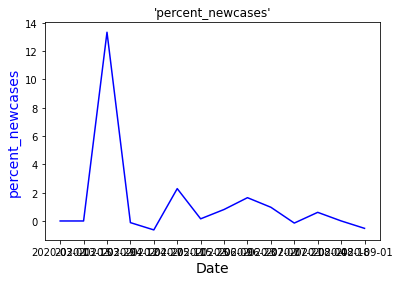

In [ ]:
fig,ax = plt.subplots()
# make a plot
ax.plot(austin_county.startDate, austin_county['percent_newcases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("percent_newcases",color="blue",fontsize=14)
# ax2=ax.twinx()
# make a plot with different y-axis using second axis object
# ax2.plot(austin_county.startDate, austin_county["percent_newcases"],color="red")
# ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'percent_newcases'")

plt.show()

In [ ]:
data = average_newCases_df2['percent_newcases'].to_list()

print(data)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [ ]:
average_newCases_df3 = average_newCases_df2.copy().reset_index(drop=True)

In [ ]:
average_newCases_df3.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
0,Anderson County,48001,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0
1,Andrews County,48003,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0
2,Angelina County,48005,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0
3,Aransas County,48007,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0
4,Archer County,48009,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0


In [ ]:
new_cases_list = average_newCases_df2['percent_newcases'].values

### Determining growth label for covid cases

In [ ]:
len(new_cases_list)

2835

In [ ]:
diffArr = np.diff(new_cases_list)
print(len(diffArr))
diffArr[0]

2834


0.0

In [ ]:
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA
print('growth_values : ',len(growth_values))
growth_values.extend(diffArr)
print('growth_values : ',len(growth_values))

growth_values :  1
growth_values :  2835


In [ ]:
len(growth_values)

2835

In [ ]:
average_newCases_df2['growth_per_day'] = growth_values

In [ ]:
average_newCases_df2.dtypes

County Name          object
fips_x                int64
average_per_week    float64
startDate            object
endDate              object
diff_avg_x          float64
shift_avg_x         float64
percent_newcases    float64
growth_per_day      float64
dtype: object

### Checking mean, std dev and variance for growth data

In [ ]:
stdDev = np.std(diffArr)
variance = np.var(diffArr)
mean = np.mean(diffArr)
min = np.min(diffArr)
max = np.max(diffArr)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

min  -2.7021597764222984e+16
max  2.7021597764222984e+16
mean  -0.0002423996178130038
std. deviation  717837429837000.0
variance  5.152905756749898e+29


#### Getting positive cases

In [ ]:
print('length diffArr: ',len(diffArr))

non_zero_pos_diff = []

for i in diffArr:
  if i > 0:
    non_zero_pos_diff.append(i)

print('non_zero_pos_diff length: ',len(non_zero_pos_diff))


length diffArr:  2834
non_zero_pos_diff length:  1219


In [ ]:
stdDev = np.std(non_zero_pos_diff)
variance = np.var(non_zero_pos_diff)
mean = np.mean(non_zero_pos_diff)
min = np.min(non_zero_pos_diff)
max = np.max(non_zero_pos_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)


min  0.0006087909411911507
max  2.7021597764222984e+16
mean  22167020315199.03
std. deviation  773625833202918.9
variance  5.984969297989104e+29


#### Getting negative cases

In [ ]:
print('length diffArr: ',len(diffArr))

non_zero_neg_diff = []

for i in diffArr:
  if i < 0:
    non_zero_neg_diff.append(i)
print("non_zero_neg_diff length : ",len(non_zero_neg_diff))

length diffArr:  2834
non_zero_neg_diff length :  1175


In [ ]:
stdDev = np.std(non_zero_neg_diff)
variance = np.var(non_zero_neg_diff)
mean = np.mean(non_zero_neg_diff)
min = np.min(non_zero_neg_diff)
max = np.max(non_zero_neg_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)


min  -2.7021597764222984e+16
max  -3.1086244689504383e-15
mean  -22997104480193.723
std. deviation  787965506980493.1
variance  6.2088964019102555e+29


### Trying natural breaks

In [ ]:
!pip install jenkspy

  Using cached https://files.pythonhosted.org/packages/53/cf/ca4619c97a1a65ae005855fbe8c9513eec4e0f4d2eefc61bf2367529827d/jenkspy-0.1.6.tar.gz
  Created wheel for jenkspy: filename=jenkspy-0.1.6-cp36-cp36m-linux_x86_64.whl size=68254 sha256=6597560b7b7fc1717d061ef88a9713f658f39ab2444b701f2382d0d5e682e665
  Stored in directory: /root/.cache/pip/wheels/5b/8c/58/5022a1b7f3121b8f7a1caaa394480d3cfbd4b439fee2a00cbf
Successfully built jenkspy


In [ ]:
import jenkspy

In [ ]:
pos_breaks = jenkspy.jenks_breaks(non_zero_pos_diff, nb_class=2)
print(pos_breaks)
neg_breaks = jenkspy.jenks_breaks(non_zero_neg_diff, nb_class=2)
print(neg_breaks)

[0.0006087909411911507, 228.38461538461536, 2.7021597764222984e+16]
[-2.7021597764222984e+16, -221.12592592592588, -3.1086244689504383e-15]


In [ ]:
def determine_growth_label(x):
  if x >= -0.002109 and x <= 0.00011:
    return 'flat_growth'
  if x > 0.00011 and x <= 39.5:
    return 'mild_growth'
  if x > 39.5 and x <= 410.1818:
    return 'drastic_growth'
  if x >= -39.5  and x <= -0.0021:
    return 'mild_decrement'
  if x >= -410.18 and x < -39.5:
    return 'drastic_decrement'

In [ ]:
average_newCases_df2['growth_label'] = average_newCases_df2['growth_per_day'].apply(lambda x: determine_growth_label(x) )

In [ ]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label
0,Anderson County,48001,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth
1,Andrews County,48003,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth
2,Angelina County,48005,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth
3,Aransas County,48007,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth
4,Archer County,48009,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth


## Jenks Natural breaks

In [ ]:
breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=3)
print(breaks)

[-28.999999999999932, 66.42857142857144, 227.99999999999997, 2.7021597764222984e+16]


In [ ]:
breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=8)
print(breaks)

[-28.999999999999932, 2.013888888888888, 8.194444444444448, 19.636363636363633, 42.00000000000001, 80.3181818181818, 154.60000000000002, 227.99999999999997, 2.7021597764222984e+16]


In [ ]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread1','SuperSpread2','SuperSpread3','SuperSpread4','SuperSpread5','SuperSpread6'])

In [ ]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['County Name'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['County Name'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread1']['County Name'].count())
print('Number of records in SuperSpread2:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['County Name'].count())


print('Number of records in SuperSpread3:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread3']['County Name'].count())

print('Number of records in SuperSpread4:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread4']['County Name'].count())

print('Number of records in SuperSpread5:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread5']['County Name'].count())

print('Number of records in SuperSpread6:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread6']['County Name'].count())

Number of records in LessSpread: 2411
Number of records in Spread: 301
Number of records in SuperSpread: 79
Number of records in SuperSpread2: 24
Number of records in SuperSpread3: 10
Number of records in SuperSpread4: 5
Number of records in SuperSpread5: 3
Number of records in SuperSpread6: 1


In [ ]:
import jenkspy

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=4)
print(breaks)

[-28.999999999999932, 14.999999999999996, 80.3181818181818, 227.99999999999997, 2.7021597764222984e+16]


In [ ]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread','SuperSpread2'])

In [ ]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['County Name'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['County Name'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']['County Name'].count())

print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['County Name'].count())

Number of records in LessSpread: 2770
Number of records in Spread: 55
Number of records in SuperSpread: 8
Number of records in SuperSpread: 1


In [ ]:
average_newCases_df2.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label,labels
0,Anderson County,48001,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread
1,Andrews County,48003,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread
2,Angelina County,48005,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread
3,Aransas County,48007,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread
4,Archer County,48009,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,0.0,flat_growth,LessSpread


## 1.3 Labeling data for CA combined

In [ ]:
TX_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases
0,2020-03-01,48001,Anderson County,16.0,15.0,0.0,0.0,3.0,0.0,27.49,8.910,79,54.333710,0,0.0,0,0.0
15118,2020-03-01,48215,Hidalgo County,20.0,7.0,14.0,12.0,0.0,-3.0,-2.07,6.021,81,553.010115,0,0.0,0,0.0
26462,2020-03-01,48373,Polk County,25.0,19.0,0.0,0.0,3.0,0.0,23.02,10.595,84,48.579591,0,0.0,0,0.0
15307,2020-03-01,48217,Hill County,22.0,11.0,0.0,13.0,3.0,0.0,72.23,14.110,62,38.221430,0,0.0,0,0.0
15496,2020-03-01,48219,Hockley County,15.0,14.0,0.0,0.0,3.0,0.0,-33.99,3.309,45,25.342639,0,0.0,0,0.0


In [ ]:
TX_combined_data_ = TX_combined_data.copy()

In [ ]:
TX_combined_data = TX_combined_data_.copy().reset_index(drop=True)

In [ ]:
#average_newCases_df = pd.DataFrame(columns=['County Name',  'fips_x',  'average_per_week','startDate','endDate'])

for index, row in (average_newCases_df2.iterrows()):
    startDate, endDate = row['startDate'], row['endDate']
    fips = row['fips_x']
    #print(startDate,endDate,fips)
    df_index = (TX_combined_data['fips_x'] == row['fips_x']) & (TX_combined_data['Date'] >= startDate) & (TX_combined_data['Date'] <= endDate)
    df_weekData =  TX_combined_data.loc[df_index]
    #print(df_weekData)
    TX_combined_data.loc[df_index,'label'] = row['labels']
    TX_combined_data.loc[df_index,'growth_label'] = row['growth_label']

In [ ]:
TX_combined_data.head()

,Date,fips_x,County Name,retail and recreation,grocery and pharmacy,parks,transit stations,workplaces,residential,driving,m50,m50_index,population_density,mask_rule_active,mask_wearing_percent,New cases,rolling_avg_new_cases,label,growth_label
0,2020-03-01,48001,Anderson County,16.0,15.0,0.0,0.0,3.0,0.0,27.49,8.910,79,54.333710,0,0.0,0,0.0,LessSpread,flat_growth
1,2020-03-01,48215,Hidalgo County,20.0,7.0,14.0,12.0,0.0,-3.0,-2.07,6.021,81,553.010115,0,0.0,0,0.0,LessSpread,flat_growth
2,2020-03-01,48373,Polk County,25.0,19.0,0.0,0.0,3.0,0.0,23.02,10.595,84,48.579591,0,0.0,0,0.0,LessSpread,flat_growth
3,2020-03-01,48217,Hill County,22.0,11.0,0.0,13.0,3.0,0.0,72.23,14.110,62,38.221430,0,0.0,0,0.0,LessSpread,flat_growth
4,2020-03-01,48219,Hockley County,15.0,14.0,0.0,0.0,3.0,0.0,-33.99,3.309,45,25.342639,0,0.0,0,0.0,LessSpread,flat_growth


In [ ]:
TX_combined_data[TX_combined_data['label'] == 'SuperSpread2'].sort_values(by=['fips_x','Date']).count()

Date                     28
fips_x                   28
County Name              28
retail and recreation    28
grocery and pharmacy     28
parks                    28
transit stations         28
workplaces               28
residential              28
driving                  28
m50                      28
m50_index                28
population_density       28
mask_rule_active         28
mask_wearing_percent     28
New cases                28
rolling_avg_new_cases    28
label                    28
growth_label              0
dtype: int64

In [ ]:
TX_combined_data.shape

(73558, 19)

In [ ]:
TX_combined_data['label'] = TX_combined_data['label'].apply(lambda x: x if x != 'SuperSpread2' else 'SuperSpread')

In [ ]:
TX_combined_data.dtypes

Date                      object
fips_x                     int64
County Name               object
retail and recreation    float64
grocery and pharmacy     float64
parks                    float64
transit stations         float64
workplaces               float64
residential              float64
driving                  float64
m50                      float64
m50_index                  int64
population_density       float64
mask_rule_active           int64
mask_wearing_percent     float64
New cases                  int64
rolling_avg_new_cases    float64
label                     object
growth_label              object
dtype: object

In [ ]:
TX_combined_data[TX_combined_data['label'] == 'LessSpread'].count()

Date                     71808
fips_x                   71808
County Name              71808
retail and recreation    71808
grocery and pharmacy     71808
parks                    71808
transit stations         71808
workplaces               71808
residential              71808
driving                  71808
m50                      71808
m50_index                71808
population_density       71808
mask_rule_active         71808
mask_wearing_percent     71808
New cases                71808
rolling_avg_new_cases    71808
label                    71808
growth_label             71788
dtype: int64

In [ ]:
TX_combined_data[TX_combined_data['growth_label'] == 'flat_growth'].count()

Date                     11762
fips_x                   11762
County Name              11762
retail and recreation    11762
grocery and pharmacy     11762
parks                    11762
transit stations         11762
workplaces               11762
residential              11762
driving                  11762
m50                      11762
m50_index                11762
population_density       11762
mask_rule_active         11762
mask_wearing_percent     11762
New cases                11762
rolling_avg_new_cases    11762
label                    11762
growth_label             11762
dtype: int64

## Export Combined labeled Data

In [ ]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/'
filename = 'TX_labeledData_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
TX_combined_data.to_csv(location+filename,index=False)

TX_labeledData_Sep16.csv


In [ ]:
average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,growth_per_day,growth_label,labels
216,Bell County,48027,1.377551,2020-03-15,2020-03-28,1.367347,0.010204,134.000000,134.000000,drastic_growth,SuperSpread
217,Bexar County,48029,5.714286,2020-03-15,2020-03-28,5.683673,0.030612,185.666667,51.666667,drastic_growth,SuperSpread
221,Brazoria County,48039,2.275510,2020-03-15,2020-03-28,2.255102,0.020408,110.500000,110.500000,drastic_growth,SuperSpread
260,El Paso County,48141,1.377551,2020-03-15,2020-03-28,1.367347,0.010204,134.000000,134.000000,drastic_growth,SuperSpread
271,Galveston County,48167,2.010204,2020-03-15,2020-03-28,2.000000,0.010204,196.000000,196.000000,drastic_growth,SuperSpread
379,Travis County,48453,7.938776,2020-03-15,2020-03-28,7.887755,0.051020,154.600000,154.600000,drastic_growth,SuperSpread
462,Ector County,48135,2.336735,2020-03-29,2020-04-11,2.326531,0.010204,228.000000,228.384615,drastic_growth,SuperSpread
951,Ochiltree County,48357,2.028571,2020-04-27,2020-05-10,2.012698,0.015873,126.800000,126.745355,drastic_growth,SuperSpread


## Kernal Density Estimation

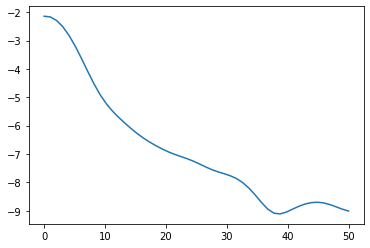

In [ ]:
%matplotlib inline

from numpy import array, linspace
from sklearn.neighbors.kde import KernelDensity
from matplotlib.pyplot import plot

a = array(data).reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(a)
s = linspace(0,50)
e = kde.score_samples(s.reshape(-1,1))
plot(s, e)

In [ ]:
from scipy.signal import argrelextrema
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi])
print("Maxima:", s[ma])

Minima: [38.7755102]
Maxima: [44.89795918]


In [ ]:
lower_range = s[mi][0]
upper_range = s[mi][1]

lower_range

IndexError: ignored

In [ ]:
print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


IndexError: ignored

In [ ]:
plot(s[:mi[0]+1], e[:mi[0]+1], 'r',
     s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g',
     s[mi[1]:], e[mi[1]:], 'b',
     s[ma], e[ma], 'go',
     s[mi], e[mi], 'ro')

IndexError: ignored

## Labeling Data with Kernal density results

In [ ]:
average_newCases_df3.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases
0,Anderson County,48001,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0
1,Andrews County,48003,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0
2,Angelina County,48005,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0
3,Aransas County,48007,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0
4,Archer County,48009,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0


In [ ]:
print(lower_range, upper_range)

NameError: ignored

In [ ]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range  else 'SuperSpread')

In [ ]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range else ('Spread' if (x >= lower_range and x <= upper_range) else 'SuperSpread'))

NameError: ignored

In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'lessSpread'].count()

County Name         2814
fips_x              2814
average_per_week    2814
startDate           2814
endDate             2814
diff_avg_x          2814
shift_avg_x         2609
percent_newcases    2814
label               2814
dtype: int64

In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'Spread'].count()

County Name         0
fips_x              0
average_per_week    0
startDate           0
endDate             0
diff_avg_x          0
shift_avg_x         0
percent_newcases    0
label               0
dtype: int64

In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'SuperSpread'].count()

County Name         21
fips_x              21
average_per_week    21
startDate           21
endDate             21
diff_avg_x          21
shift_avg_x         21
percent_newcases    21
label               21
dtype: int64

In [ ]:
average_newCases_df3.head()

,County Name,fips_x,average_per_week,startDate,endDate,diff_avg_x,shift_avg_x,percent_newcases,label
0,Anderson County,48001,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,lessSpread
1,Andrews County,48003,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,lessSpread
2,Angelina County,48005,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,lessSpread
3,Aransas County,48007,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,lessSpread
4,Archer County,48009,0.0,2020-03-01,2020-03-14,0.0,NaN,0.0,lessSpread


## 2.1 Loading CA - Social Distancing Inertia Maryland Data

In [ ]:
TX_combined_sd_inertia_data = pd.read_csv('/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/TX_socialDistancingInertiaData_Sep10.csv',low_memory=False)
TX_combined_sd_inertia_data.head()

FileNotFoundError: ignored

In [ ]:
TX_combined_sd_inertia_data.FIPS.unique()

NameError: ignored

In [ ]:
TX_combined_sd_inertia_data.columns

In [ ]:
TX_combined_sd_inertia_data.iloc[:,5]

In [ ]:
df = pd.DataFrame(columns=['Date', 'Province_State', 'FIPS',  'New cases',
        'mask_rule_active', 'CTFIPS', 'CTNAME', 'STFIPS',
       'Social distancing index', '% staying home', 'Trips/person',
       '% out-of-county trips', '% out-of-state trips', 'Miles/person',
       'Work trips/person', 'Non-work trips/person', 'New COVID cases',
       'Population', '% change in consumption', 'date', 'Transit mode share',
       '% people older than 60', 'Median income', '% African Americans',
       '% Hispanic Americans', '% Male', 'Population density',
       'Employment density', '# hot spots/1000 people',
       'Hospital beds/1000 people', 'ICUs/1000 people',
       '# contact tracing workers/1000 people',
       '# contact tracing workers/1000 people rank',
       '% people older than 60 rank', 'COVID exposure/1000 people',
        'Unemployment claims/1000 people',
       'Unemployment rate', '% working from home', 'Cumulative inflation rate',
        '% hospital bed utilization',
       'Testing capacity', 'Tests done/1000 people', '% ICU utilization',
       'Ventilator shortage'])

In [ ]:
TX_counties = TX_combined_sd_inertia_data['CTNAME'].unique()

for county in CA_counties:
  county_data = TX_combined_sd_inertia_data[TX_combined_sd_inertia_data['CTNAME'] == county]
  #print(county_data.iloc[:,15])
  county_data['rolling_avg_new_cases'] = county_data.iloc[:,5].rolling(window=7).mean()
  df = df.append(county_data)

df.head()

In [ ]:
print(df.shape)
TX_combined_sd_inertia_data.shape

In [ ]:
TX_combined_sd_inertia_data = df.copy()
TX_combined_sd_inertia_data

In [ ]:
TX_combined_sd_inertia_data.head(3)

### clean data - fill NA

In [ ]:
TX_combined_sd_inertia_data = TX_combined_sd_inertia_data.fillna(0)
TX_combined_sd_inertia_data.head(4)

In [ ]:
TX_combined_sd_inertia_data['CTNAME'].unique()

verifying Rolling average with visualizations

In [ ]:
austin_county = TX_combined_sd_inertia_data[TX_combined_sd_inertia_data['CTNAME'] == 'Austin County']
print(austin_county.shape)
austin_county.head()

In [ ]:
fig,ax = plt.subplots()
# make a plot
ax.plot(austin_county.Date, austin_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(austin_county.Date, austin_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

In [ ]:
dallas_county = TX_combined_sd_inertia_data[TX_combined_sd_inertia_data['CTNAME'] == 'Dallas County']

In [ ]:
fig,ax = plt.subplots()
# make a plot
ax.plot(dallas_county.Date, dallas_county['rolling_avg_new_cases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("rolling_avg_new_cases",color="blue",fontsize=14)
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(dallas_county.Date, dallas_county["New cases"],color="red")
ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'rolling_avg_new_cases' Vs New cases")

plt.show()

### Rolling window to compare every 2 weeks with next 2 weeks

In [ ]:
TX_combined_sd_inertia_data = TX_combined_sd_inertia_data.sort_values(by=['Date'])
TX_combined_sd_inertia_data.head()

In [ ]:
TX_combined_sd_inertia_data[TX_combined_sd_inertia_data['FIPS'] == 48015]

In [ ]:
minDate = TX_combined_sd_inertia_data['Date'].min()
print(minDate)

dateList = TX_combined_sd_inertia_data['Date'].unique()

In [ ]:
import datetime

#dt_object = datetime.fromtimestamp(date)
day_name= ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']

day = datetime.datetime.strptime(minDate, '%Y-%m-%d').weekday()
if day == 6:
  day =0
elif day < 6:
  day += 1

print(day)

In [ ]:
index = 0
count = 0
lst = []
while index < len(dateList):
  row = []
  j = 14 - day;
  # print(index,j)
  # print(dateList[index:index+j])
  weekRange = dateList[index:index+j]
  #print(weekRange)
  index = index+j 
  day = 0
  count +=1
  row.append(count)
  row.append(weekRange.min())
  row.append(weekRange.max())
  print(row)
  lst.append(row)

In [ ]:
week_df = pd.DataFrame(lst,index=None,columns=['WeekNumber','startDate','endDate'])
week_df.head(2)

### Slice data for the week dataframe

In [ ]:
average_newCases_df = pd.DataFrame(columns=['CTNAME',  'FIPS',  'average_per_week','startDate','endDate'])

for index, row in week_df.iterrows():
    startDate, endDate = row['startDate'], row['endDate']
    df_index = (TX_combined_sd_inertia_data['Date'] >= startDate) & (TX_combined_sd_inertia_data['Date'] <= endDate)
    df_weekData =  TX_combined_sd_inertia_data.loc[df_index]
    df_base = (
      df_weekData
      .pipe(lambda x: x.assign(gains_pctg=x["rolling_avg_new_cases"]))
      .groupby(['CTNAME','FIPS'])
      .agg({"gains_pctg": "mean"})
      .reset_index()
      .rename(columns={"gains_pctg": "average_per_week"})
    )
    df_base['startDate'] = startDate
    df_base['endDate'] = endDate
  
    #print(startDate,endDate,df_base['average_per_week'])
    average_newCases_df = average_newCases_df.append(df_base)

In [ ]:
average_newCases_df.shape

In [ ]:
average_newCases_df[average_newCases_df['FIPS'] == 48015]

### Verifying average per week data Eg., Los Angeles County

In [ ]:
austin_county[(austin_county['Date'] >= '2020-03-01') & (austin_county['Date'] <= '2020-03-14') ]['rolling_avg_new_cases']

In [ ]:
average_newCases_df.head(10)

### Finding the % growth or reduction in 'new cases' on every 2 week average

In [ ]:
average_newCases_df_ = average_newCases_df.copy()

In [ ]:
albany_avg_newCases = average_newCases_df[average_newCases_df['CTNAME'] == 'Austin County']
albany_avg_newCases

In [ ]:
average_newCases_df.head()

In [ ]:
average_newCases_df2 = average_newCases_df.copy()

average_newCases_df2 = average_newCases_df2.reset_index(drop=True)
average_newCases_df2.head()

In [ ]:
average_newCases_df2['diff_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['CTNAME', 'FIPS'])['average_per_week'].diff().fillna(0)

print(average_newCases_df2.shape)
average_newCases_df2.head()

In [ ]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Dallas County']

In [ ]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Houston County']

In [ ]:
average_newCases_df2[average_newCases_df2['FIPS'] == 48015].head(5)

In [ ]:
average_newCases_df2.head()

In [ ]:
average_newCases_df2 = average_newCases_df2.fillna(0)

In [ ]:
average_newCases_df2.head()

In [ ]:
average_newCases_df2['shift_avg_x'] = average_newCases_df2.sort_values(['startDate','endDate']).groupby(['CTNAME', 'FIPS'])['average_per_week'].shift()

In [ ]:
average_newCases_df2.groupby(by=['CTNAME', 'FIPS','startDate','endDate']).sum()

In [ ]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Austin County']

In [ ]:
average_newCases_df2['percent_newcases'] = average_newCases_df2.apply(lambda x: (x.diff_avg_x) / x.shift_avg_x if x.shift_avg_x > 0.0 else 0 , axis=1)


average_newCases_df2.tail()

In [ ]:
average_newCases_df2[average_newCases_df2['CTNAME'] == 'Dallas County']

## 2.2 Labeling data as per % change

In [ ]:
average_newCases_df2.describe()

In [ ]:
austin_county = average_newCases_df2[average_newCases_df2['CTNAME'] == 'Austin County']

In [ ]:
fig,ax = plt.subplots()
# make a plot
ax.plot(austin_county.startDate, austin_county['percent_newcases'], color="blue")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("percent_newcases",color="blue",fontsize=14)
# ax2=ax.twinx()
# make a plot with different y-axis using second axis object
# ax2.plot(austin_county.startDate, austin_county["percent_newcases"],color="red")
# ax2.set_ylabel("New cases",color="blue",fontsize=14)
plt.title("'percent_newcases'")

plt.show()

In [ ]:
data = average_newCases_df2['percent_newcases'].to_list()

print(data)

In [ ]:
average_newCases_df3 = average_newCases_df2.copy().reset_index(drop=True)

### Determining growth label

In [ ]:
new_cases_list = average_newCases_df2['percent_newcases'].values
diffArr = np.diff(new_cases_list)
print(len(diffArr))
diffArr[0]

In [ ]:
growth_values =[]
growth_values.append(0.0) # making first value as 0, as np.diff leaves first values as NA

print('growth_values : ',len(growth_values))
growth_values.extend(diffArr)
print('growth_values : ',len(growth_values))

In [ ]:
average_newCases_df2['growth_per_day'] = growth_values

Checking mean, std dev and variance for growth data

In [ ]:
stdDev = np.std(diffArr)
variance = np.var(diffArr)
mean = np.mean(diffArr)
min = np.min(diffArr)
max = np.max(diffArr)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)


Positive cases

In [ ]:
print('length diffArr: ',len(diffArr))

non_zero_pos_diff = []

for i in diffArr:
  if i > 0:
    non_zero_pos_diff.append(i)

print('non_zero_pos_diff length: ',len(non_zero_pos_diff))

In [ ]:
stdDev = np.std(non_zero_pos_diff)
variance = np.var(non_zero_pos_diff)
mean = np.mean(non_zero_pos_diff)
min = np.min(non_zero_pos_diff)
max = np.max(non_zero_pos_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)


Negative Cases

In [ ]:
print('length diffArr: ',len(diffArr))

non_zero_neg_diff = []

for i in diffArr:
  if i < 0:
    non_zero_neg_diff.append(i)
print("non_zero_neg_diff length : ",len(non_zero_neg_diff))


In [ ]:
stdDev = np.std(non_zero_neg_diff)
variance = np.var(non_zero_neg_diff)
mean = np.mean(non_zero_neg_diff)
min = np.min(non_zero_neg_diff)
max = np.max(non_zero_neg_diff)


print("min ",min)
print("max ",max)

print("mean ",mean)
print("std. deviation ",stdDev)
print("variance ",variance)

### Applying Jenks Natural break

In [ ]:
pos_breaks = jenkspy.jenks_breaks(non_zero_pos_diff, nb_class=2)
print(pos_breaks)
neg_breaks = jenkspy.jenks_breaks(non_zero_neg_diff, nb_class=2)
print(neg_breaks)


In [ ]:
def determine_growth_label_inertia(x):
  if x >= -0.0021 and x <= 0.0017:
    return 'flat_growth'
  if x > 0.0017 and x <= 39.5:
    return 'mild_growth'
  if x > 39.5 and x <= 410.1818:
    return 'drastic_growth'
  if x >= -39.5  and x <= -0.0021:
    return 'mild_decrement'
  if x >= -410.1818 and x < -39.5:
    return 'drastic_decrement'


In [ ]:
average_newCases_df2['growth_label'] = average_newCases_df2['growth_per_day'].apply(lambda x: determine_growth_label_inertia(x) )


## Jenks Natural breaks

In [ ]:
!pip install jenkspy

In [ ]:
import jenkspy

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=3)
print(breaks)

In [ ]:
import jenkspy

breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=4)
print(breaks)


In [ ]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread','SuperSpread2'])


In [ ]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['CTNAME'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['CTNAME'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']['CTNAME'].count())

print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['CTNAME'].count())


In [ ]:
breaks = jenkspy.jenks_breaks(average_newCases_df2['percent_newcases'], nb_class=8)
print(breaks)


In [ ]:
average_newCases_df2['labels'] = pd.cut(average_newCases_df2['percent_newcases'],
                        bins=breaks,
                        labels=['LessSpread','Spread', 'SuperSpread1','SuperSpread2','SuperSpread3','SuperSpread4','SuperSpread5','SuperSpread6'])


In [ ]:
print('Number of records in LessSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'LessSpread']['CTNAME'].count())
print('Number of records in Spread:',average_newCases_df2[average_newCases_df2['labels'] == 'Spread']['CTNAME'].count())
print('Number of records in SuperSpread:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread1']['CTNAME'].count())
print('Number of records in SuperSpread2:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread2']['CTNAME'].count())
print('Number of records in SuperSpread3:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread3']['CTNAME'].count())
print('Number of records in SuperSpread4:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread4']['CTNAME'].count())
print('Number of records in SuperSpread5:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread5']['CTNAME'].count())
print('Number of records in SuperSpread6:',average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread6']['CTNAME'].count())


In [ ]:
average_newCases_df2.head()

## 2.3 Labeling data for CA -Maryland Social Distancing Inertia combined

In [ ]:
TX_combined_sd_inertia_data.head(2)

In [ ]:
TX_combined_sd_inertia_data_ = TX_combined_sd_inertia_data.copy()

In [ ]:
TX_combined_sd_inertia_data = TX_combined_sd_inertia_data_.copy().reset_index(drop=True)

In [ ]:
for index, row in tqdm(average_newCases_df2.iterrows()):
    startDate, endDate = row['startDate'], row['endDate']
    fips = row['FIPS']
    #print(startDate,endDate,fips)
    df_index = (TX_combined_sd_inertia_data['FIPS'] == row['FIPS']) & (TX_combined_sd_inertia_data['Date'] >= startDate) & (TX_combined_sd_inertia_data['Date'] <= endDate)
    df_weekData =  TX_combined_sd_inertia_data.loc[df_index]
    #print(df_weekData)
    TX_combined_sd_inertia_data.loc[df_index,'label'] = row['labels']
    TX_combined_sd_inertia_data.loc[df_index,'growth_label'] = row['growth_label']

In [ ]:
TX_combined_sd_inertia_data.head(5)

In [ ]:
TX_combined_sd_inertia_data[TX_combined_sd_inertia_data['label'] == 'SuperSpread2'].sort_values(by=['FIPS','Date']).count()

In [ ]:
TX_combined_sd_inertia_data.shape

In [ ]:
TX_combined_sd_inertia_data['label'] = TX_combined_sd_inertia_data['label'].apply(lambda x: x if x != 'SuperSpread2' else 'SuperSpread')

### Export

In [ ]:
from datetime import datetime
location = '/content/drive/Shared drives/CMPE 295- Master Project/Covid19-data/'
filename = 'TX_sd_inertia_labeledData_'+datetime.now().strftime("%b%d")+'.csv' #%Y%m%d
print(filename)
TX_combined_sd_inertia_data.to_csv(location+filename,index=False)

In [ ]:
average_newCases_df2[average_newCases_df2['labels'] == 'SuperSpread']

### Kernal Density Estimation

In [ ]:
%matplotlib inline

from numpy import array, linspace
from sklearn.neighbors.kde import KernelDensity
from matplotlib.pyplot import plot

a = array(data).reshape(-1, 1)
kde = KernelDensity(kernel='gaussian', bandwidth=3).fit(a)
s = linspace(0,50)
e = kde.score_samples(s.reshape(-1,1))
plot(s, e)

In [ ]:
from scipy.signal import argrelextrema
mi, ma = argrelextrema(e, np.less)[0], argrelextrema(e, np.greater)[0]
print("Minima:", s[mi])
print("Maxima:", s[ma])

In [ ]:
lower_range = s[mi][0]
upper_range = s[mi][1]

lower_range

In [ ]:
print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])

In [ ]:
print(a[a < mi[0]], a[(a >= mi[0]) * (a <= mi[1])], a[a >= mi[1]])


### Labeling Data with Kernal density results

In [ ]:
average_newCases_df3.head()


In [ ]:
print(lower_range, upper_range)


In [ ]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range  else 'SuperSpread')


In [ ]:
average_newCases_df3['label'] = average_newCases_df3['percent_newcases'].apply(lambda x: 'lessSpread' if x < lower_range else ('Spread' if (x >= lower_range and x <= upper_range) else 'SuperSpread'))

In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'lessSpread'].count()

In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'Spread'].count()

In [ ]:
average_newCases_df3[average_newCases_df3['label'] == 'SuperSpread'].count()

In [ ]:
average_newCases_df3[average_newCases_df3['growth_label'] == 'SuperSpread'].count()

In [ ]:
average_newCases_df3.head()